In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self,init_pose):
        self.pose = init_pose
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        

In [3]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,init_pose,num,motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particl のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
    
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録

In [8]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)
        self.prev_nu,self.prev_omega = self.nu,self.omega
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        elems.append(ax.text(0,0,"hoge",fontsize = 10))

In [5]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(initial_pose,100,motion_noise_stds = {"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})
a = EstimationAgent(0.1,0.2,10.0 / 180 * math.pi,0.1)
estimator.motion_update(0.2,10.0 / 180 * math.pi,0.1)
for p in estimator.particles:
    print(p.pose)


[0.01698419 0.000129   0.01519066]
[0.01730046 0.0001302  0.01505125]
[0.02090174 0.00023374 0.02236429]
[0.02002932 0.00029682 0.02963615]
[0.01985404 0.00014999 0.01510897]
[0.01468622 0.00012757 0.0173729 ]
[0.0244948  0.00019927 0.01627015]
[0.01757679 0.00011631 0.01323447]
[0.01626748 0.00033023 0.04059412]
[0.01866471 0.00022661 0.02428148]
[0.01739327 0.00023356 0.02685529]
[1.63966904e-02 8.16331631e-05 9.95719095e-03]
[2.25254230e-02 7.73743560e-05 6.86993109e-03]
[0.02454084 0.00013635 0.01111224]
[0.02320411 0.0001095  0.00943761]
[0.02211618 0.0001821  0.01646701]
[0.01846244 0.00020773 0.02250186]
[0.01990846 0.00018212 0.01829545]
[0.02182675 0.00021664 0.01984981]
[0.01961899 0.0002936  0.02992798]
[2.26313239e-02 6.66258429e-05 5.88791454e-03]
[0.02043717 0.00011155 0.01091625]
[0.01766253 0.00026411 0.02990385]
[0.02111952 0.00022878 0.0216646 ]
[0.01838295 0.00016776 0.01825104]
[0.01707982 0.00013076 0.01531165]
[0.01331861 0.00017555 0.02636059]
[1.91998726e-02 7.2

<IPython.core.display.Javascript object>


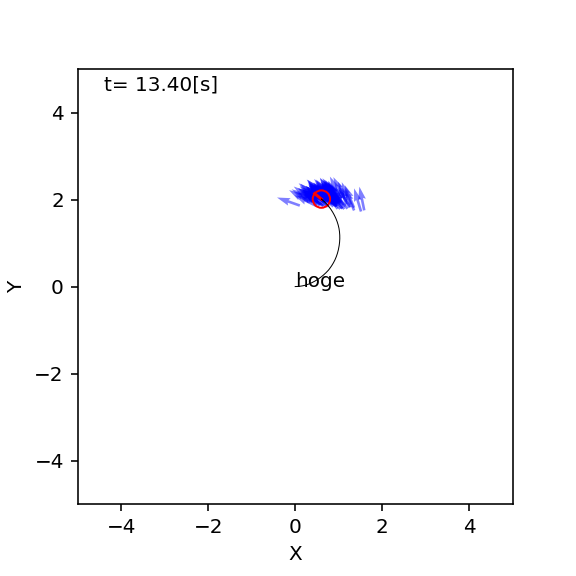

In [9]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(15,time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100,motion_noise_stds)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = None,agent = circling,color = "red")
    world.append(r)
    
    world.draw()
    
trial({"nn":0.01,"no":0.001,"on":0.13,"oo":0.001})
# noiseのパラメタがテキトーなので、robotと粒子が乖離してしまう